# SOC stock change by land cover type
### Python libraries

In [1]:
import sys
sys.path.append("../../processing/")

import os 

import pandas as pd
from dotenv import load_dotenv
from dask.distributed import Client

from utils.data import VectorData, LandCoverData
from utils.raster import read_zarr_from_s3, read_zarr_from_local_dir
from utils.calculations import LandCoverStatistics

# Load .env VARIABLEs
load_dotenv()

True

In [2]:
client = Client()  # start distributed scheduler locally.  Launch dashboard
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 15.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35407,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 15.00 GiB
Comm: tcp://127.0.0.1:39041,Total threads: 4
Dashboard: http://127.0.0.1:44771/status,Memory: 3.75 GiB
Nanny: tcp://127.0.0.1:46337,


### Compute Land Cover Statistics

In [4]:
RASTER_PATH = '../data/processed/raster_data/'
vector_path = '../data/processed/vector_data/'
vector_prefixes = ['political_boundaries']#['political_boundaries', 'biomes']
read_data_from = 'local_dir'
variable = 'stocks'
group_type = 'recent'
READ_DATA_FROM = 'local_dir'

# Read vector data
print("Reading vector data!")
vector = VectorData(vector_path, vector_prefixes)
vector_data_0 = vector.read_data(suffix='_0.geojson')
vector_data_1 = vector.read_data(suffix='_1.geojson')

# Read raster data
print("Reading raster data!")
lc_metadata = LandCoverData()
# read Recent dataset
file = 'global-dataset.zarr'
dataset = 'global-dataset'
group = 'recent'
if READ_DATA_FROM == 's3':
    ds = read_zarr_from_s3(access_key_id = os.getenv("S3_ACCESS_KEY_ID"), 
                        secret_accsess_key = os.getenv("S3_SECRET_ACCESS_KEY"),
                        dataset = dataset, group = group) 
elif READ_DATA_FROM == 'local_dir':
    ds = read_zarr_from_local_dir(path=os.path.join(RASTER_PATH, file), group = group)
    
ds = ds.drop_dims('depth').sel(time=['2000-12-31T00:00:00.000000000', '2018-12-31T00:00:00.000000000'])

# read land cover dataset
file = 'land-cover.zarr'
dataset = 'land-cover'
if READ_DATA_FROM == 's3':
    ds_lc = read_zarr_from_s3(access_key_id = os.getenv("S3_ACCESS_KEY_ID"), 
                            secret_accsess_key = os.getenv("S3_SECRET_ACCESS_KEY"),
                            dataset = dataset) 
elif READ_DATA_FROM == 'local_dir':
    ds_lc = read_zarr_from_local_dir(path=os.path.join(RASTER_PATH, file))
    
ds['land-cover'] = ds_lc['land-cover']

raster_data = ds


# Compute Land Cover Statistics
print("Compute Land Cover Statistics!")
vector_data_0['political_boundaries_0'] = vector_data_0['political_boundaries_0'][vector_data_0['political_boundaries_0']['gid_0'].isin(['ESP'])]
vector_data_1['political_boundaries_1'] = vector_data_1['political_boundaries_1'][vector_data_1['political_boundaries_1']['gid_0'].isin(['ESP'])]

data = {}
lc_statistics = LandCoverStatistics(raster_data, lc_metadata)
# compute level 1 geometries' values
print("Level 1 geometries.")
data.update(lc_statistics.compute_level_1_data(vector_data_1))
# compute level 0 geometries' values
print("Level 0 geometries.")
data.update(lc_statistics.compute_level_0_data(vector_data_0))

### Save data
#print("Saving the data!")
#for geom_type in vector_prefixes:
#    df = pd.concat([data[key] for key in data if geom_type in key])
#    df = df.sort_values(['id_0', 'id'])
#    df['variable'] = variable
#    df['group_type'] = group_type
##   df.to_csv(f"../data/processed/precalculations/{geom_type}_land_cover_{group_type}.csv", index=False)
client.close()

Reading vector data!


100%|██████████| 1/1 [00:10<00:00, 10.99s/it]


Reading raster data!
Compute Land Cover Statistics!
Level 1 geometries.
Computing land cover statistics for vector data -> political_boundaries_1


100%|██████████| 49/49 [01:27<00:00,  1.78s/it]


Level 0 geometries.
Computing land cover statistics for vector data -> political_boundaries_0


100%|██████████| 2/2 [00:00<00:00, 365.10it/s]


### Display data

In [7]:
import matplotlib.pyplot as plt

In [8]:
def get_plot(data, land_cover_colors, land_cover_labels):
    categories = list(data.keys())

    lists_labels = [list(value.keys()) for value in data.values()]
    labels = list(set([item for sublist in lists_labels for item in sublist]))


    # Calculate the positions of the bars on the y-axis
    bar_positions = range(len(categories))

    # Create the plot
    fig, ax = plt.subplots()

    for n, label in enumerate(labels):
        values_positive = []
        values_negative = []
        for category in categories[::-1]:
            data_dict = data[category]
            if label in data_dict.keys():
                value = data_dict[label]
                if value > 0:
                    values_positive.append(value)
                    values_negative.append(0)
                else:
                    values_negative.append(value)
                    values_positive.append(0)
            else:
                values_negative.append(0)
                values_positive.append(0)

        if n == 0:
            ax.barh(bar_positions, values_positive, label=land_cover_labels[label], color=land_cover_colors[label])
            ax.barh(bar_positions, values_negative, color=land_cover_colors[label])

            values_positive_pre = values_positive
            values_negative_pre = values_negative
        elif n == 1:
            ax.barh(bar_positions, values_positive, left=values_positive_pre, label=land_cover_labels[label],
                    color=land_cover_colors[label])
            ax.barh(bar_positions, values_negative, left=values_negative_pre, color=land_cover_colors[label])

            values_positive_pre = [values_positive_pre[i] + values_positive[i] for i in range(len(values_positive))]
            values_negative_pre = [values_negative_pre[i] + values_negative[i] for i in range(len(values_negative))]
        else:
            ax.barh(bar_positions, values_positive, left=values_positive_pre, label=land_cover_labels[label],
                    color=land_cover_colors[label])
            ax.barh(bar_positions, values_negative, left=values_negative_pre, color=land_cover_colors[label])

            values_positive_pre = [values_positive_pre[i] + values_positive[i] for i in range(len(values_positive))]
            values_negative_pre = [values_negative_pre[i] + values_negative[i] for i in range(len(values_negative))]

    # Add a dashed line at x = 0
    ax.axvline(0, color='black', linestyle='dashed')

    ## Set the y-axis ticks and labels
    ax.set_yticks(bar_positions)
    categories = [land_cover_labels[str(category)] for category in categories]
    ax.set_yticklabels(categories[::-1])
    ax.yaxis.set_ticks_position('none')
    ax.set_ylabel('Land Cover 2018')

    # Set the x-axis label
    ax.set_xlabel('SOC stock change (t C/ha)')

    # Remove the frame
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add a legend
    legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Set the title of the legend
    legend.set_title('Land Cover 2000')

    # Expand the plot's size to accommodate the legend
    plt.subplots_adjust(right=0.8)

    return plt

In [10]:
lc_metadata = LandCoverData()
df = data['political_boundaries_0'][data['political_boundaries_0']['gid_0'] == 'FRA']

land_cover_groups = df['land_cover_groups'].iloc[0]
land_cover_group_2018 = df['land_cover_group_2018'].iloc[0]
land_cover = df['land_cover'].iloc[0]

lc_list = list(land_cover_groups.keys())

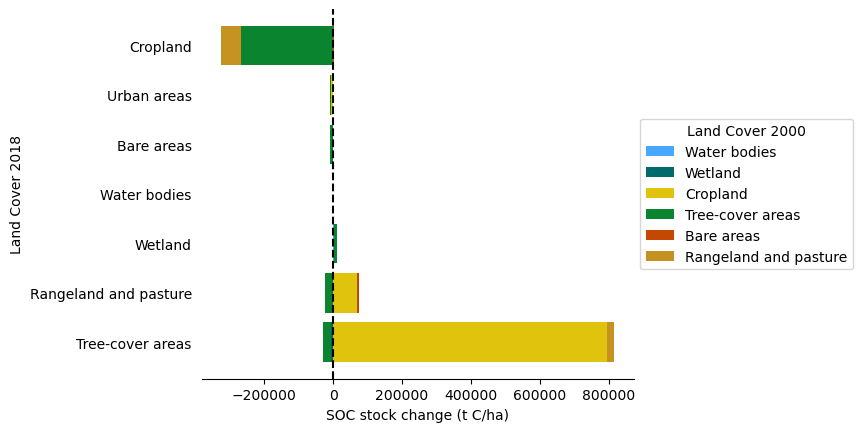

In [11]:
plt = get_plot(land_cover_groups, lc_metadata.parent_colors(), lc_metadata.parent_labels())

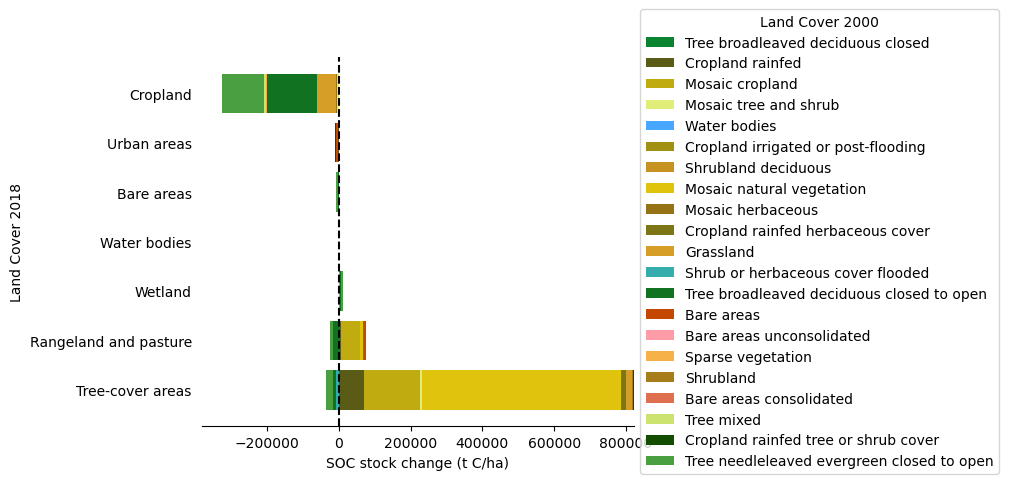

In [12]:
labels = lc_metadata.parent_labels()
labels.update(lc_metadata.child_labels())
colors = lc_metadata.parent_colors()
colors.update(lc_metadata.child_colors())
plt = get_plot(land_cover_group_2018, colors, labels)

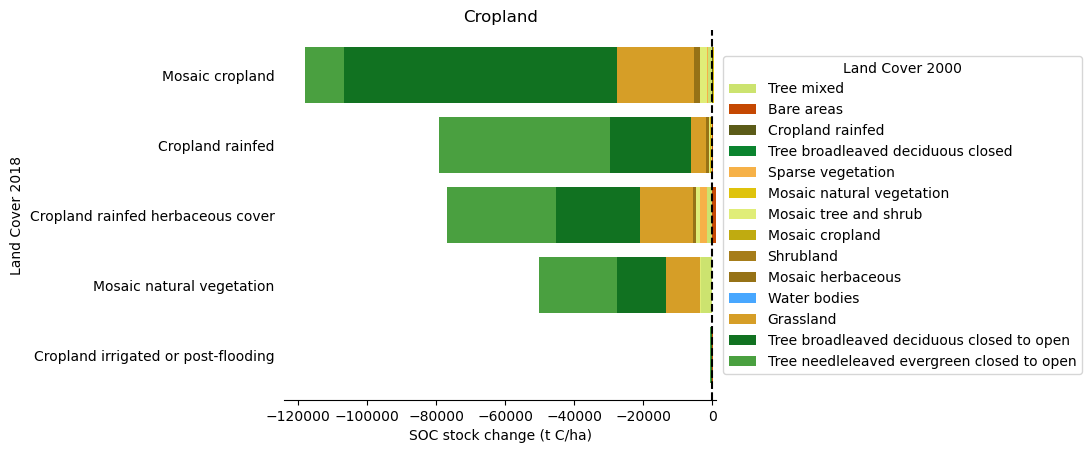

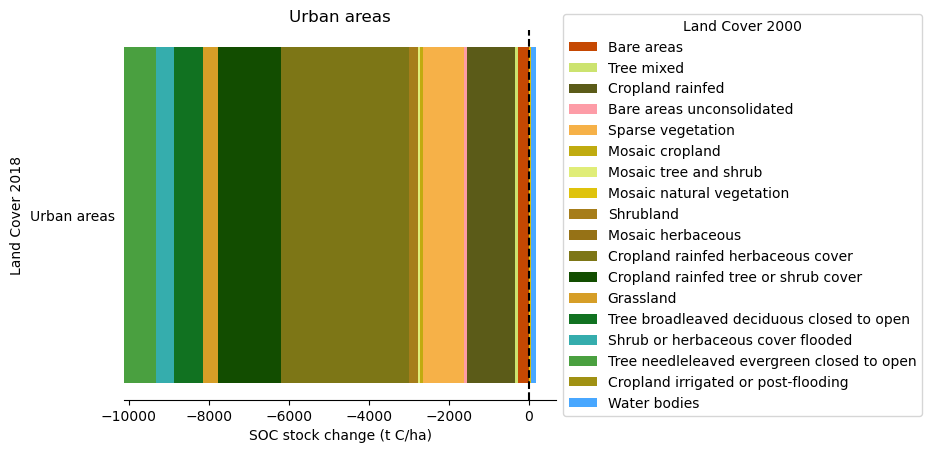

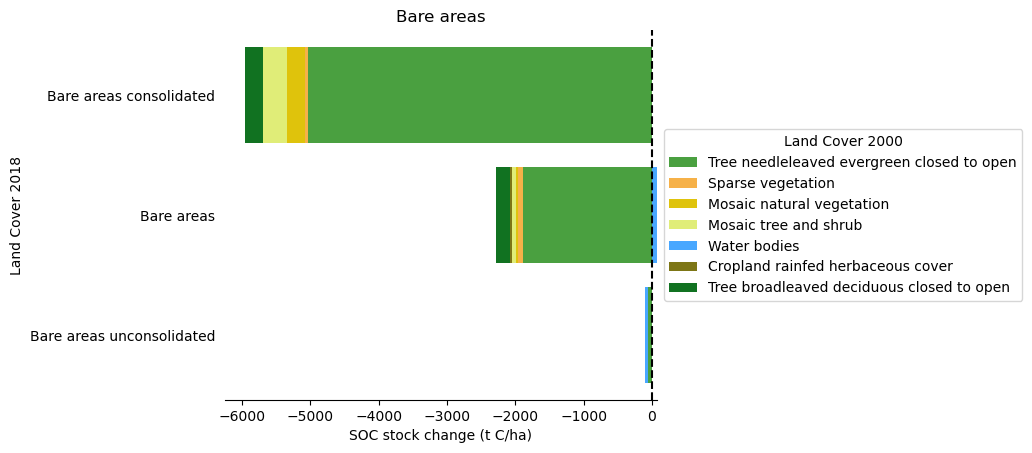

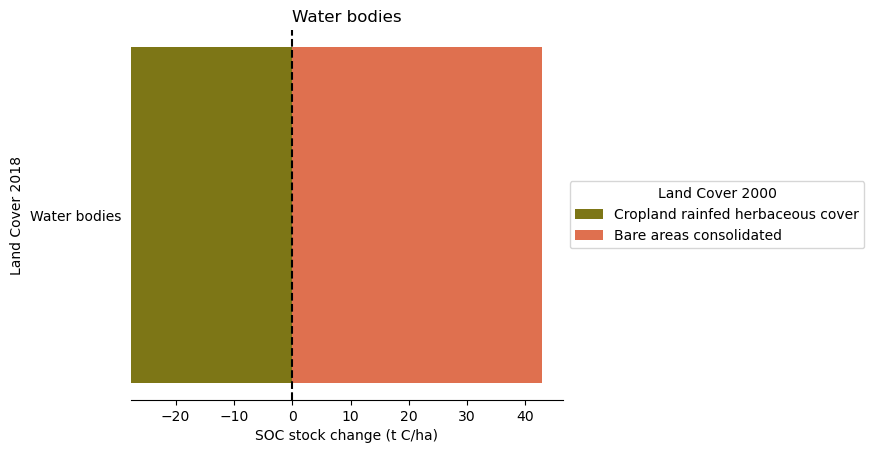

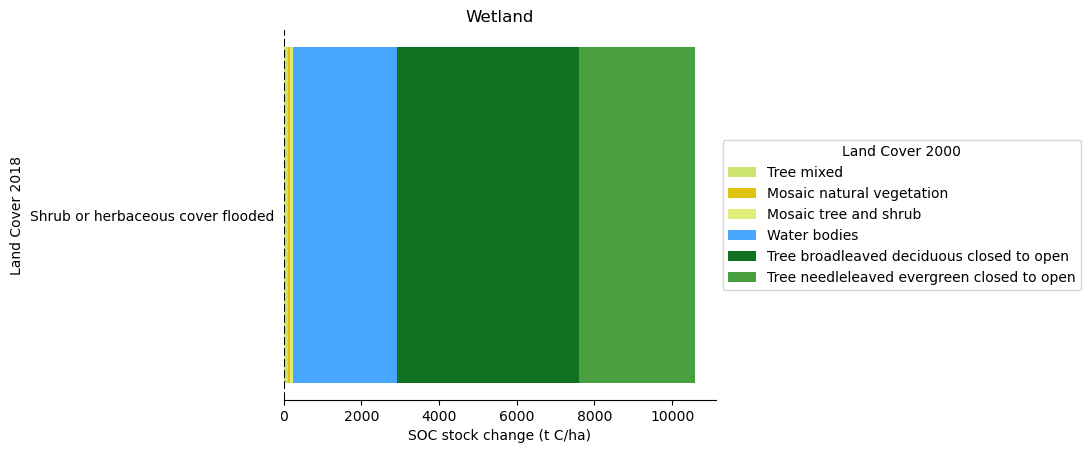

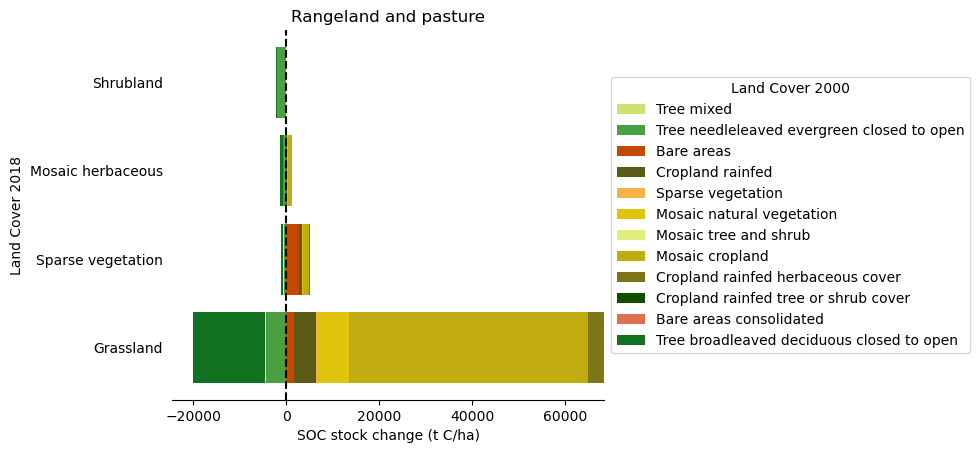

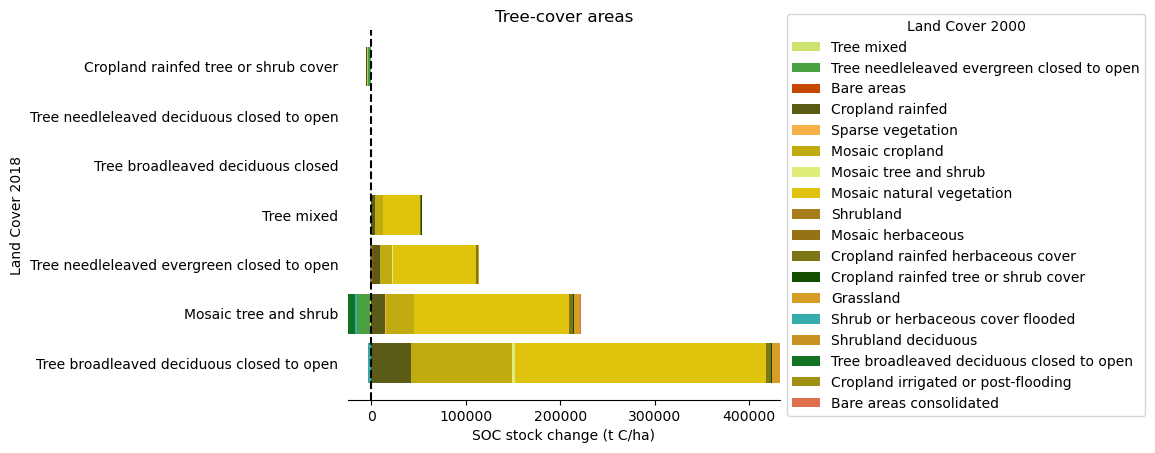

In [13]:
for num in lc_list:
    plt = get_plot(df['land_cover'].iloc[0][num], lc_metadata.child_colors(), lc_metadata.child_labels())
    plt.title(labels[num])